This notebook shows how to use `LimeExplainer` class of AI4Water. The `LimeExplainer` class is a wrapper around [LIME](https://github.com/marcotcr/lime) library. I helps in making plots which explain individual examples/samples of data. 

In [1]:
try:
    import AI4Water
except ImportError:
    !python -m pip install "AI4Water[all] @ git+https://github.com/AtrCheema/AI4Water.git"

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
tf.__version__

'1.15.0'

In [3]:
import numpy as np
np.printoptions(suppress=True)
np.__version__

'1.19.5'

In [4]:
from ai4water import Model
from ai4water.datasets import MtropicsLaos
from ai4water.post_processing.explain import LimeExplainer
from ai4water.post_processing.explain import explain_model_with_lime
from ai4water.utils.visualizations import regplot

Note: If you are having trouble due to tqdm package, your make sure you have latest version of ipywidgets as as been reported [here](https://github.com/pytorch/pytorch/issues/52813#issuecomment-787664718)

In [5]:
laos = MtropicsLaos()
data = laos.make_regression()


Not downloading the data since the directory 
D:\mytools\AI4Water\ai4water\datasets\data\MtropicsLaos already exists.
Use overwrite=True to remove previously saved files and download again


preprocessing of shapefiles can not be done because no fiona installation is found.
Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


In [6]:
data.shape

(650741, 8)

In [7]:
data.isna().sum()

temp                 0
rel_hum              0
wind_speed           0
sol_rad              0
water_level          0
pcp                  0
susp_pm              0
Ecoli_mpn100    650483
dtype: int64

In [8]:
data.dropna()

,temp,rel_hum,wind_speed,sol_rad,water_level,pcp,susp_pm,Ecoli_mpn100
2011-05-25 16:36:00,22.90,100.00,2.2000,34.8000,144.600000,0.0,0.900000,1100.0
2011-05-25 17:06:00,22.90,100.00,2.9000,6.0000,147.800000,0.0,0.990000,1400.0
2011-05-25 17:24:00,22.90,100.00,2.6000,6.0000,149.100000,0.0,1.330000,14000.0
2011-05-25 17:42:00,22.90,100.00,2.3000,6.0000,151.800000,0.0,0.960000,1300.0
2011-05-25 18:06:00,22.90,100.00,1.9000,5.8000,149.300000,0.0,0.740000,29000.0
...,...,...,...,...,...,...,...,...
2018-09-09 14:24:00,31.76,65.76,0.8172,245.0016,142.307339,0.0,0.536700,3100.0
2018-09-19 15:24:00,30.66,76.32,0.2442,140.0472,143.900000,0.0,2.998118,0.0
2018-09-29 17:12:00,28.84,80.28,0.1376,19.6872,140.094382,0.0,2.048727,250.0
2018-10-09 14:12:00,32.96,57.96,0.2842,221.8536,138.405556,0.0,1.118183,200.0


Plot the target data

<AxesSubplot:>

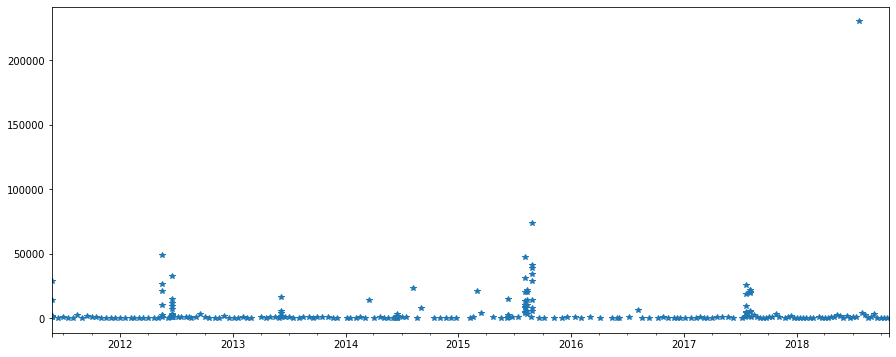

In [9]:
plt.close('all')
data['Ecoli_mpn100'].plot(style="*", figsize=(15, 6))

There is a significant high value of E. coli in the middle of 2018. 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

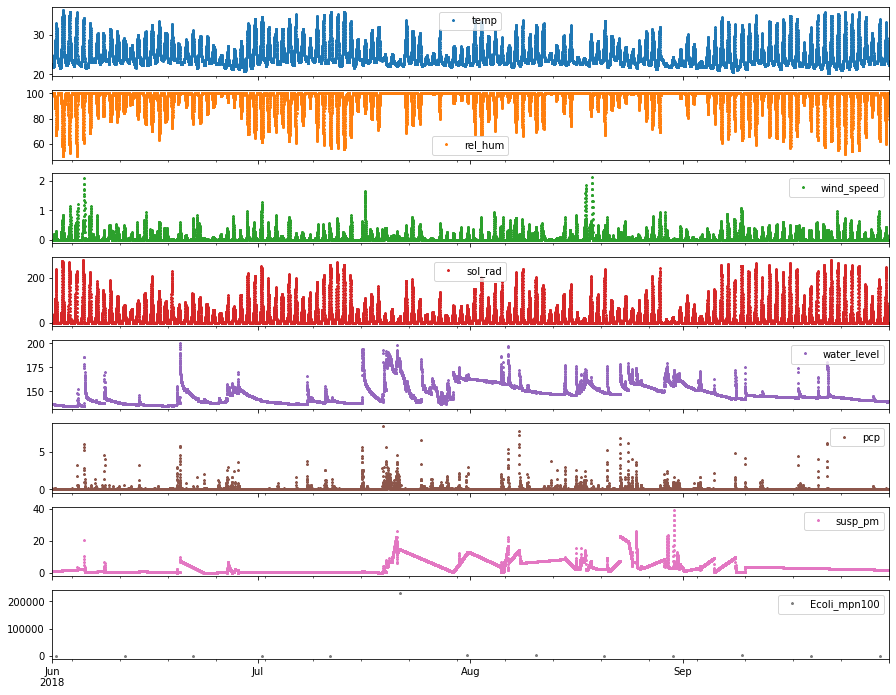

In [10]:
data.loc["20180601":"20180930"].plot(style="*", subplots=True, figsize=(15, 12), ms=2.5)

Among input features, what really changes towards end of July, is the water level. So we would expect that to assert significant influence on model's prediction for this example

In [11]:
model = Model(model="XGBoostRegressor",
             data=data)

building ML model for  regression problem using XGBoostRegressor


In [12]:
model.fit()


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (165, 7)
target shape:  (165, 1, 1)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (52, 7)
target shape:  (52, 1, 1)


divide by zero encountered in true_divide
divide by zero encountered in log
invalid value encountered in log


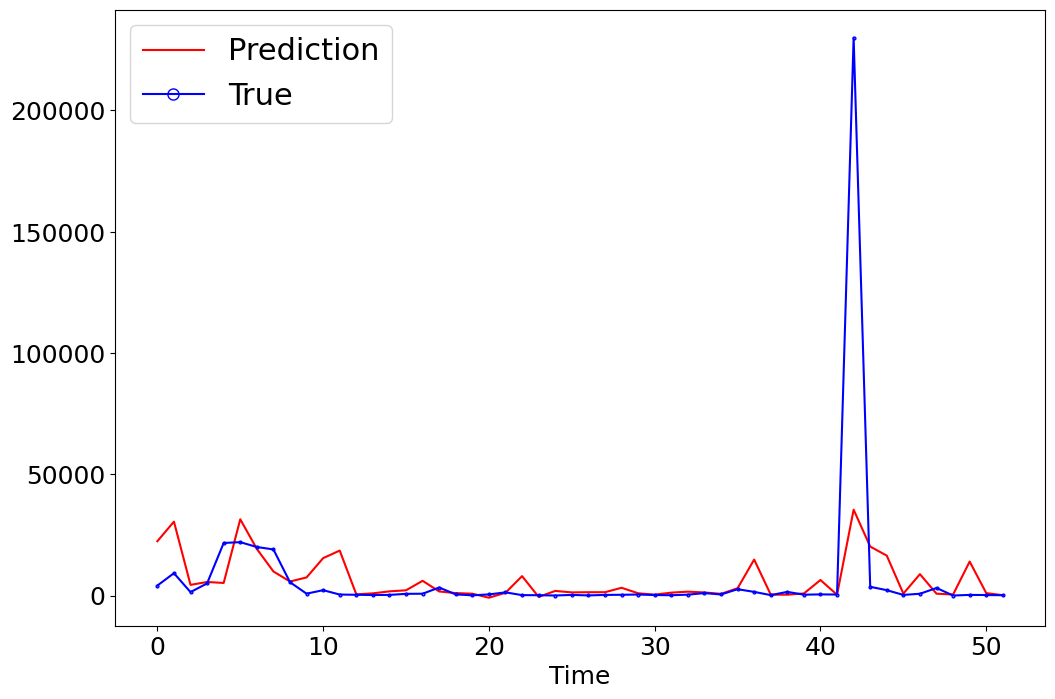

In [13]:
y_true, y_pred = model.predict(return_true=True)

<AxesSubplot:xlabel='Observed', ylabel='Predicted'>

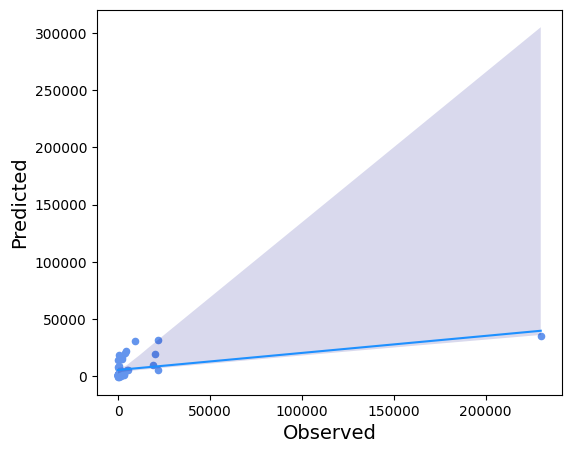

In [14]:
regplot(y_true, y_pred)


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (165, 7)
target shape:  (165, 1, 1)


divide by zero encountered in true_divide
divide by zero encountered in log


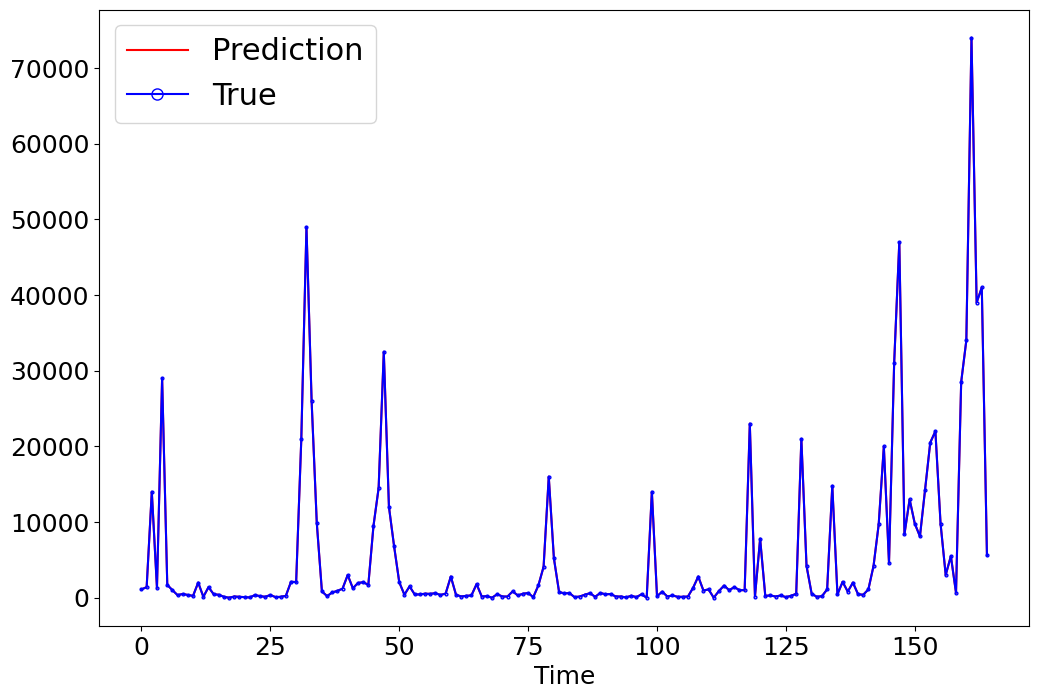

In [15]:
y_true, y_pred = model.predict('training', return_true=True)

<AxesSubplot:xlabel='Observed', ylabel='Predicted'>

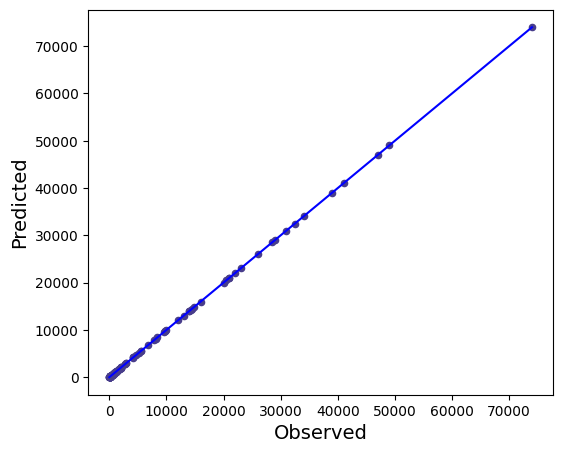

In [34]:
regplot(y_true, y_pred)

In [17]:
train_x, train_y = model.training_data()


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (165, 7)
target shape:  (165, 1, 1)


In [18]:
test_x, test_y = model.test_data()


********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (52, 7)
target shape:  (52, 1, 1)


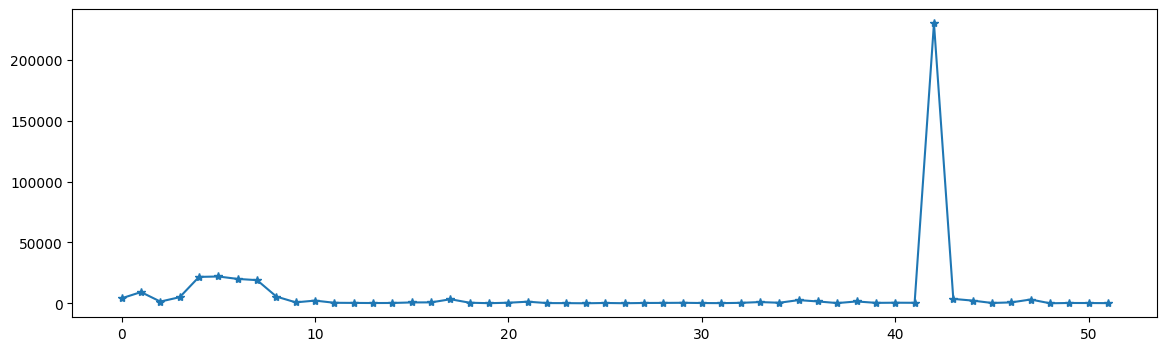

In [19]:
_, axis = plt.subplots(figsize=(14, 4))
axis.plot(test_y.reshape(-1,), '-*')

In [20]:
for idx, val in enumerate(test_y.reshape(-1,)):
    print(idx, val)

0 4100.0
1 9200.0
2 1400.0
3 5000.0
4 21666.666666666668
5 22000.0
6 20000.0
7 19000.0
8 5500.0
9 760.0
10 2200.0
11 400.0
12 300.0
13 200.0
14 250.0
15 690.0
16 740.0
17 3300.0
18 450.0
19 78.0
20 450.0
21 1300.0
22 160.0
23 120.0
24 0.0
25 250.0
26 38.0
27 250.0
28 300.0
29 400.0
30 200.0
31 120.0
32 350.0
33 1000.0
34 430.0
35 2600.0
36 1500.0
37 160.0
38 1500.0
39 340.0
40 460.0
41 400.0
42 230000.0
43 3600.0
44 2200.0
45 250.0
46 720.0
47 3100.0
48 0.0
49 250.0
50 200.0
51 120.0


In [21]:
explainer = LimeExplainer(model._model,
                          test_x,
                          train_data=train_x, # the data on which model was trained
                          path=model.path,
                          features=model.dh.input_features, # names of features
                          mode=model.mode)

Intercept 2223.8176919444495
Prediction_local [17910.95285586]
Right: 22391.523


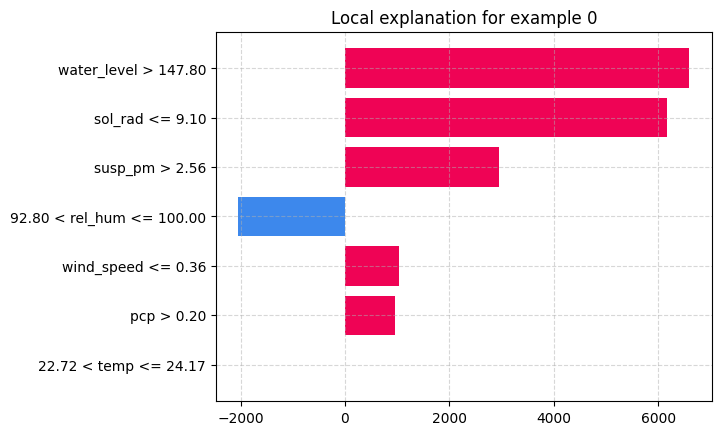

In [22]:
explainer.explain_example(0)

Intercept 6772.296893082776
Prediction_local [4071.29605386]
Right: 305.66354


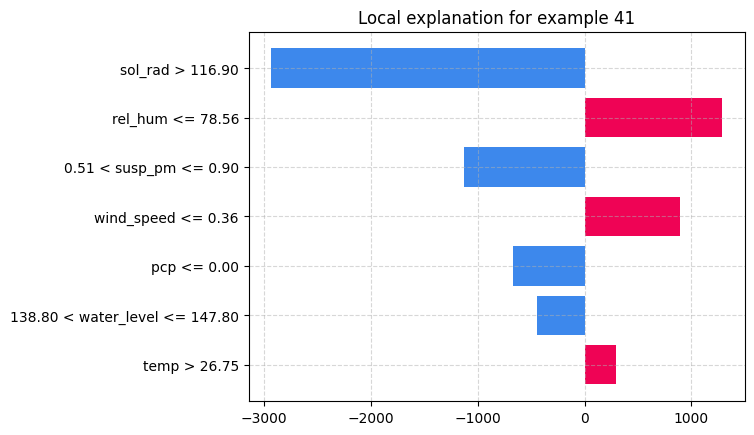

In [23]:
explainer.explain_example(41)

Intercept 4617.9806096263255
Prediction_local [12528.9529118]
Right: 35397.41


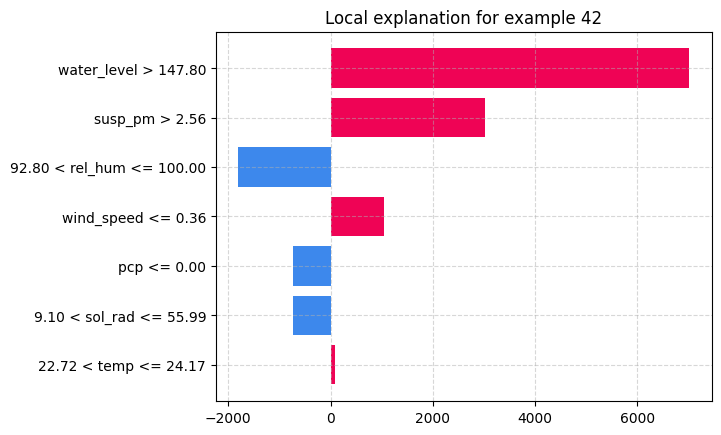

In [24]:
explainer.explain_example(42)

Intercept 5163.130267053624
Prediction_local [11202.32731671]
Right: 20191.898


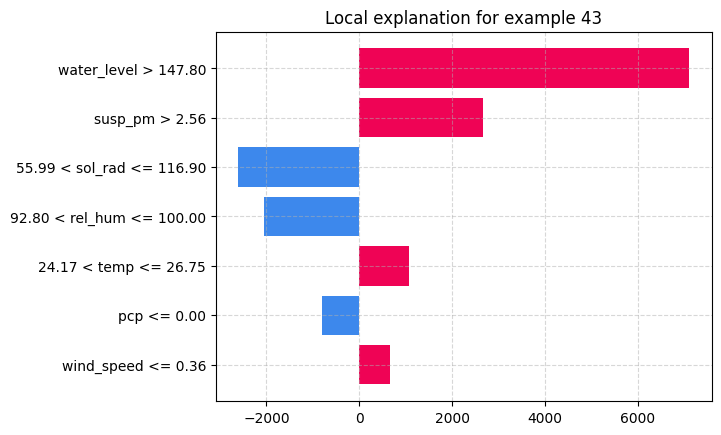

In [25]:
explainer.explain_example(43)

Intercept 3238.6591248316104
Prediction_local [13793.49662121]
Right: 16435.896


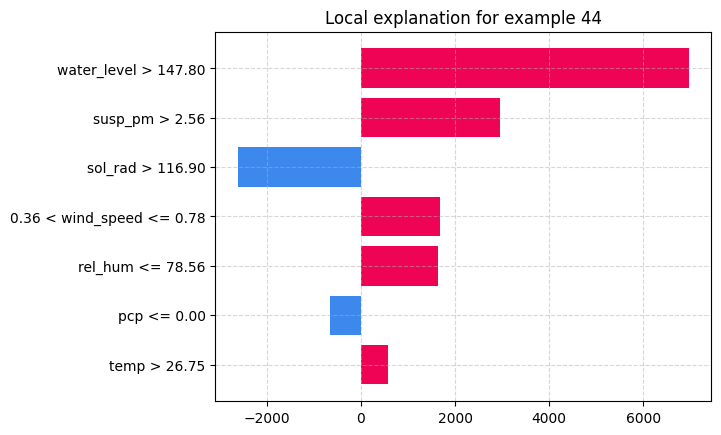

In [26]:
explainer.explain_example(44)

Intercept 5010.57899727061
Prediction_local [9067.34375106]
Right: 777.7844


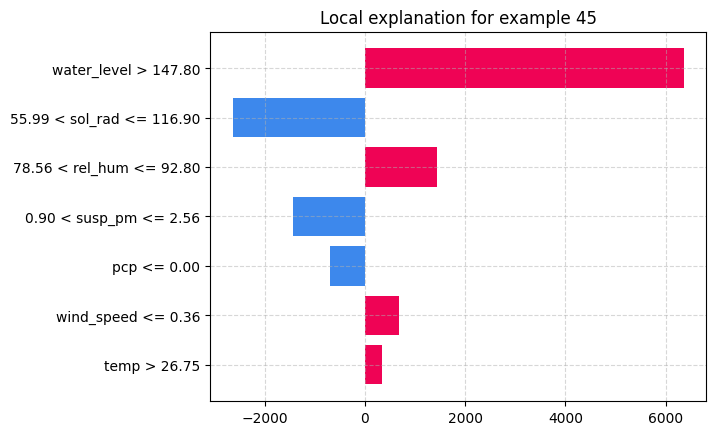

In [27]:
explainer.explain_example(45)

Intercept 3910.5992467439232
Prediction_local [13426.83584757]
Right: 8807.3125


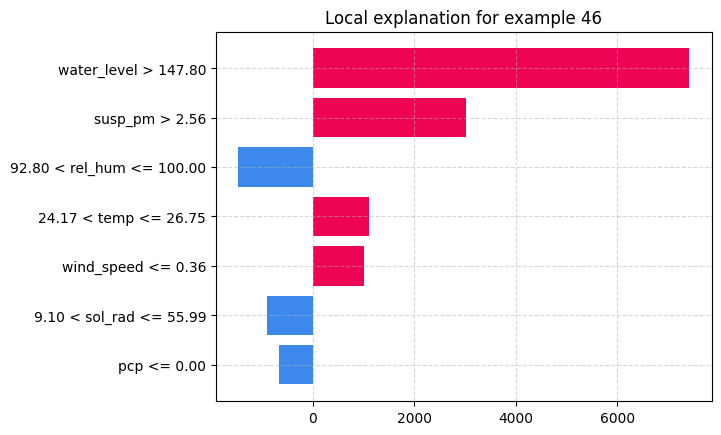

In [28]:
explainer.explain_example(46)

In [29]:
explainer = LimeExplainer(model._model,
                          train_x,
                          train_data=train_x, # the data on which model was trained
                          path=model.path,
                          features=model.dh.input_features, # names of features
                          mode=model.mode)

In [30]:
for idx, val in enumerate(train_y.reshape(-1,)):
    print(idx, val)

0 1100.0
1 1400.0
2 14000.0
3 1300.0
4 29000.0
5 1700.0
6 1000.0
7 340.0
8 500.0
9 360.0
10 250.0
11 2000.0
12 120.0
13 1400.0
14 460.0
15 390.0
16 120.0
17 0.0
18 160.0
19 120.0
20 78.0
21 38.0
22 350.0
23 210.0
24 120.0
25 360.0
26 78.0
27 120.0
28 250.0
29 2100.0
30 2075.0
31 21000.0
32 49000.0
33 26000.0
34 9900.0
35 830.0
36 210.0
37 700.0
38 900.0
39 1200.0
40 3000.0
41 1250.0
42 1950.0
43 2050.0
44 1700.0
45 9500.0
46 14500.0
47 32500.0
48 12000.0
49 6800.0
50 2050.0
51 400.0
52 1500.0
53 430.0
54 440.0
55 530.0
56 510.0
57 600.0
58 360.0
59 550.0
60 2800.0
61 410.0
62 160.0
63 250.0
64 300.0
65 1800.0
66 160.0
67 210.0
68 0.0
69 470.0
70 160.0
71 160.0
72 840.0
73 300.0
74 530.0
75 620.0
76 78.0
77 1650.0
78 4100.0
79 16000.0
80 5200.0
81 760.0
82 570.0
83 620.0
84 78.0
85 160.0
86 400.0
87 600.0
88 120.0
89 630.0
90 450.0
91 490.0
92 160.0
93 160.0
94 38.0
95 260.0
96 78.0
97 450.0
98 0.0
99 14000.0
100 200.0
101 800.0
102 160.0
103 300.0
104 120.0
105 120.0
106 160.0
107 1310

Intercept 8644.703102759084
Prediction_local [1728.07749883]
Right: 1100.4574


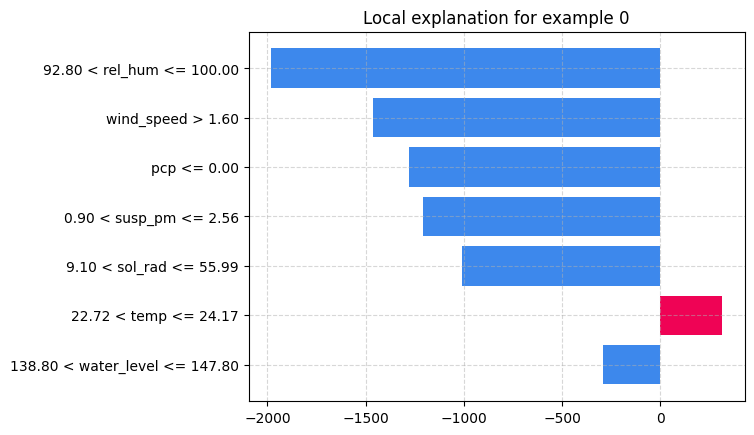

In [31]:
explainer.explain_example(0)

Intercept 4598.31862951945
Prediction_local [11811.91224958]
Right: 28997.088


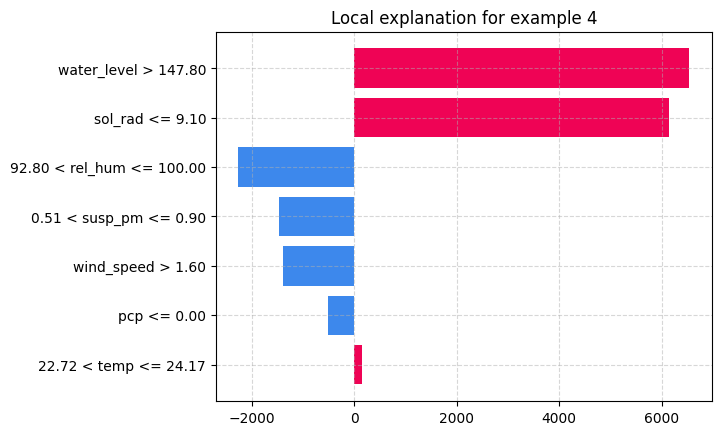

In [32]:
explainer.explain_example(4)

Intercept 6685.6551196863375
Prediction_local [5651.14976442]
Right: 339.83234


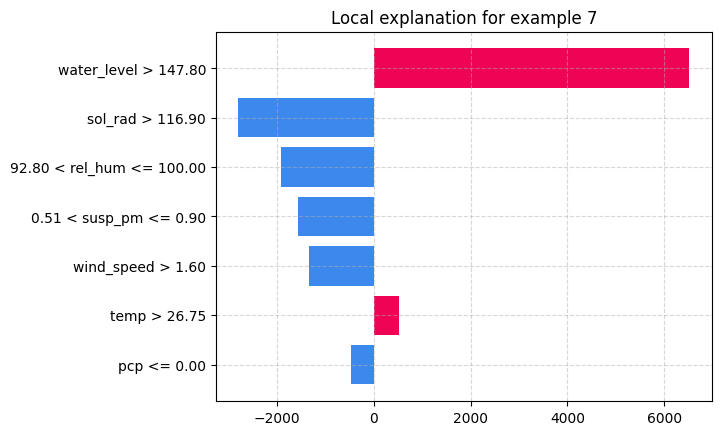

In [33]:
explainer.explain_example(7)